In the foloowing we introduce the basic components of a finite
element method:

- constructing a tesselation of the computational domain
- setting up a discrete function space and working with functions
  defined over the grid
- defining the mathematical model to solve
- solving the (non linear) system arising from the discretization of the
  model by the Galerkin method

In [1]:
import time, numpy, math, sys, io
import dune.plotting
dune.plotting.block = True
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
from matplotlib import pyplot

# Setting up the Mesh

In [2]:
from dune.grid import structuredGrid as leafGridView
gridView = leafGridView([0, 0], [1, 1], [4, 4])

# Grid Functions
These are function that are defined over a given grid and are evaluated
by using an element of the grid and local coordinated within that
element:
```
   value = gridFunction(element,localCoordinate)
```
Alternatively one can obtain a `LocalFunction` from a grid function which
can be bound to an element and then evaluate via local coordinate:
```
   localFunction = gridFunction.localFunction()
   for e in grid.elements:
       localFunction.bind(e)
       value = localFunction(x)
```
There are multiple ways to construct grid functions. The easiest way it
to use UFL expression. Many methods expecting grid functions are argument
can also directly handle UFL expression.
We can for example integrate a UFL expression over the grid:

In [3]:
from ufl import SpatialCoordinate, triangle
x = SpatialCoordinate(triangle)

exact = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

from dune.fem.function import integrate
print( integrate(gridView, exact, order=5) )

1.333333333333333


and plot them using matplotlib or write a vtk file for postprocessing

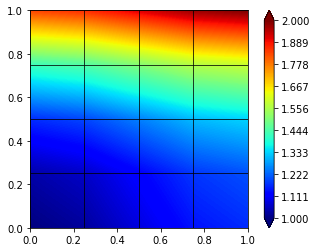

In [4]:
from dune.fem.plotting import plotPointData as plot
plot(exact, grid=gridView)
gridView.writeVTK('exact', pointdata={'exact': exact})

In some cases it can be necessary to convert a UFL expression into a grid
function explicitly - for example to be able to evaluate it over each
element in the grid:

In [5]:
from dune.fem.function import uflFunction
exact_gf = uflFunction(gridView, name="ufl", order=1, ufl=exact)
mass = 0
for element in gridView.elements:
    mass += exact_gf(element,[0.5,0.5]) * element.geometry.volume
print(mass,type(mass))

(1.328125) <class 'dune._common.FieldVector_1'>


Another way to obtain a grid function is to use the `gridFunction`
decorator. This can be obtained from `dune.grid` but then without UFL
support. Using the decorator from `dune.fem.function` the resulting grid
function can be used seamlessly within UFL expressions:

In [6]:
from dune.fem.function import gridFunction
@gridFunction(gridView,name="callback",order=1)
def exactLocal(element,xLocal):
    x = element.geometry.toGlobal(xLocal)
    return 1/2.*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

we can use the same approach but with a function using global
coordinates but can then be used like any other grid function:

In [7]:
@gridFunction(gridView,name="callback",order=1)
def exactGlobal(x):
    return 1/2.*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

lf = exactGlobal.localFunction()
mass = 0
for element in gridView.elements:
    lf.bind(element)
    mass += lf([0.5,0.5]) * element.geometry.volume
print(mass)

print( integrate(gridView, [exact,exactLocal,exactGlobal], order=5) )

1.328125


(1.333333, 1.333333, 1.333333)


As pointed out the `dune.fem` grid function can be used like any other
UFL coefficient to form UFL expressions:

6.073673799839786e-17


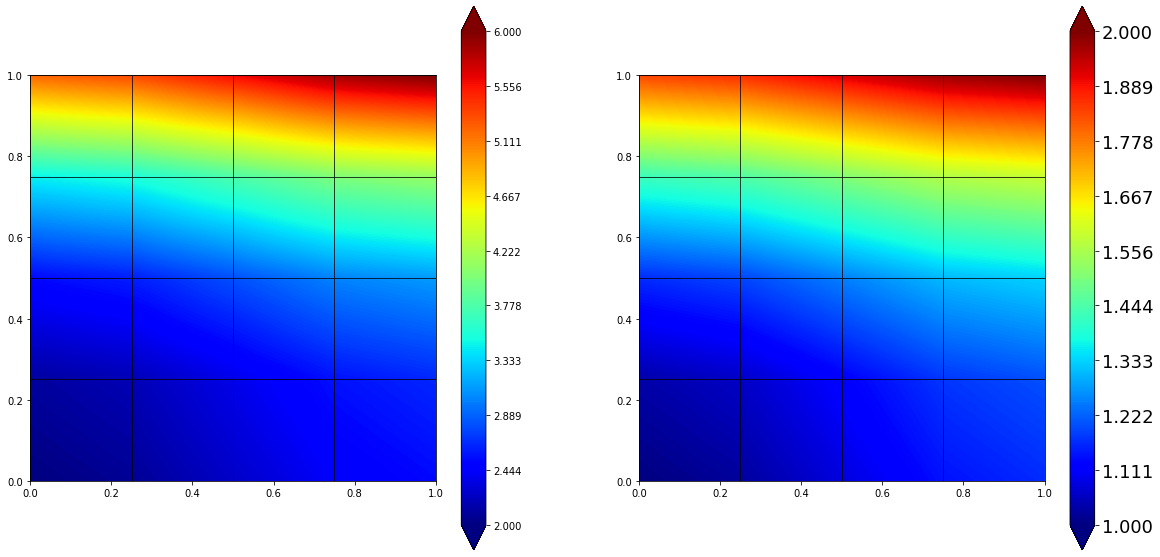

In [8]:
print( integrate(gridView, abs(exact-exactLocal), order=5) )
gf = uflFunction(gridView, name="ufl", order=1, ufl=exact+exactLocal*exactGlobal)
fig = pyplot.figure(figsize=(20,10))
gf.plot(figure=(fig,121))
exactGlobal.plot(figure=(fig,122))

Converting UFL expressions to grid functions leads to JIT code generation
and is therefore efficient when used in other C++ algorithm (like
`integrate`). On the other hand using the `gridFunction` decorator leads
to a callback into Python for each evaluation and is therefore much less
efficient. An alternative approach is based on writing small C++ snippets
implementing the grid function:

0.0


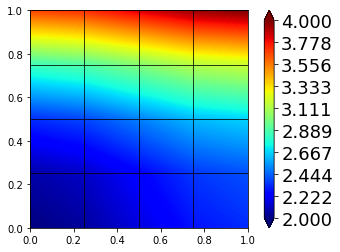

In [9]:
from dune.fem.function import cppFunction
code="""
#include <cmath>
#include <dune/common/fvector.hh>
template <class GridView>
auto aTimesExact(double a) {
  // the return value needs to be a lambda which either returns a `double`
  // or a `Dune::FieldVector<double,R>` with `R>=1`
  return [a](const auto& en,const auto& xLocal) -> auto {
    auto x = en.geometry().global(xLocal);
    return a*(1./2.*(std::pow(x[0],2)+std::pow(x[1],2)) - 1./3.*(std::pow(x[0],3) - std::pow(x[1],3)) + 1.);
  };
}
"""
exactCpp = cppFunction(gridView, name="exactCpp", order=2,
                       fctName="aTimesExact",includes=io.StringIO(code))(2.)
print( integrate(gridView, abs(2*exact-exactCpp), order=5) )
exactCpp.plot()

As the above example shows it is easy to pass in parameters to the C++
implementation - here a double `2`. Note that it is not possible to
obtain a reference to this double so to make sure a change to the
constant on the Python side carries over to the C++ side an option is to
use a `dune.common.FieldVector` instead.
These parameters can also be more complex e.g. other grid # function -
note that a UFL expression can not be directly passed in - it first needs
to be converted into a grid function using `uflFunction`.

In [10]:
code2="""
#include <cmath>
#include <dune/common/fvector.hh>
template <class GridView, class GF>
auto aTimesExact(const GF &gf,Dune::FieldVector<double,1> &a) {
  return [lgf=localFunction(gf),&a] (const auto& en,const auto& xLocal) mutable -> auto {
    lgf.bind(en); // lambda must be mutable so that the non const function can be called
    return a[0]*lgf(xLocal);
  };
}
"""
from dune.common import FieldVector
a = FieldVector([2])
exactCpp2 = cppFunction(gridView, name="exactCpp", order=2,
                        fctName="aTimesExact",includes=io.StringIO(code2))(exact_gf,a)
print( integrate(gridView, abs(exactCpp-exactCpp2), order=5) )
a[0] = 4
print( integrate(gridView, abs(2*exactCpp-exactCpp2), order=5) )

0.0


0.0


The above is just one of a few ways C++ code snippets can be used
together with Python code to improve efficiency or extend the existing
binding to Dune. In the above example there is no advantage of using the
C++ code over the code generated based on the UFL expression. For more
complicated functions e.g. with many if statements or based on more
information from the given element like it's neighbors the expressibility
of UFL might not be sufficient or lead to hard to read code. In these
cases directly providing C++ code (or Python code) can be a reasonable
alternative.

# Discrete Function Spaces
Note that the grid functions set up so far did not involve any
discretization, they are exactly evaluated at the given point.
A special type of grid functions are discrete functions living in a
discrete (finite dimensional) space.

In [11]:
from dune.fem.space import lagrange as solutionSpace
space = solutionSpace(gridView, order=2)

The easiest way to construct a discrete function is to use the interpolate
method on the discrete function space.

In [12]:
u_h = space.interpolate(exact, name='u_h')

On an existing discrete function the `interpolate` method can be used to
reinitialize it

In [13]:
u_h.interpolate( cppFunction(gridView, name="exactCpp", order=2,
                 fctName="aTimesExact",includes=io.StringIO(code))(2.) )
u_h.interpolate( lambda x: 1/2.*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1 )

Note that in the last example the Python lambda is used as a callback
automatically using the same concept used in the `gridFunction`
decorator. As pointed out above there are some methods where these
conversions are implicit and no explicit generation of a grid function
has be carried out.

If a discrete function is already available it is possible to call `copy`
to obtain further discrete functions:

In [14]:
u_h_n = u_h.copy(name="previous")

Finally, `clear` can be called on a discrete function which sets all
coefficient to zero and `assign` can be used to copy all coefficients
between two discrete function over the same space:

In [15]:
u_h_n.clear()
u_h_n.assign( u_h )

All the things we did above with grid functions can be done with discrete
functions, e.g., evaluate locally

In [16]:
localUh = u_h.localFunction()
mass = 0
for element in gridView.elements:
    localUh.bind(element) # using u_h(element,[0.5,0.5]) also works
    mass += localUh([0.5,0.5]) * element.geometry.volume
print(mass,type(mass))

(1.328125) <class 'dune._common.FieldVector_1'>


or plot using matplotlib and write a vtk file for postprocessing

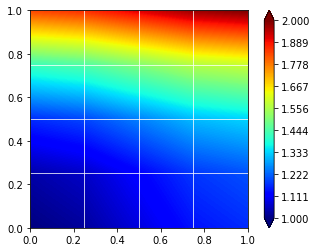

In [17]:
u_h.plot(gridLines="white")
gridView.writeVTK('uh', pointdata=[u_h])

and as before a discrete function can be used as coefficient in a UFL
expression

In [18]:
print( integrate(gridView, abs(exact-u_h), order=5) )

0.000161872374937969


Note: the discrete function `u_h` already has a `name` attribute given in
the `interpolate` call. This is used by default in the vtk file. An
alternative name can be given by using a dictionary as shown previously.

# Models and Schemes
We consider a scalar boundary value problem
\begin{align*}
-\triangle u &= f & \text{in}\;\Omega:=(0,1)^2 \\
\nabla u\cdot n &= g_N & \text{on}\;\Gamma_N \\
u &= g_D & \text{on}\;\Gamma_D
\end{align*}
and $f=f(x)$ is some forcing term.
For the boundary conditions we set $\Gamma_D={0}\times[0,1]$ and take
$\Gamma_N$ to be the remaining boundary of $\Omega$.

We will solve this problem in variational form
\begin{align*}
\int \nabla u \cdot \nabla \varphi \
- \int_{\Omega} f(x) \varphi\ dx
- \int_{\Gamma_N} g_N(x) v\ ds
= 0.
\end{align*}
We choose $f,g_N,g_D$ so that the exact solution
is given by
\begin{align*}
u(x) = \left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}

In [19]:
from ufl import TestFunction, TrialFunction
from dune.ufl import DirichletBC
u = TrialFunction(space)
v = TestFunction(space)

from ufl import dx, grad, div, grad, dot, inner, sqrt, conditional, FacetNormal, ds
a = dot(grad(u), grad(v)) * dx

f   = -div( grad(exact) )
g_N = grad(exact)
n   = FacetNormal(space)
b   = f*v*dx + dot(g_N,n)*conditional(x[0]>=1e-8,1,0)*v*ds
dbc = DirichletBC(space,exact,x[0]<=1e-8)

With the model described as a ufl form, we can construct a scheme class
that provides the solve method which we can use to compute the solution:

In [20]:
from dune.fem.scheme import galerkin as solutionScheme
scheme = solutionScheme([a == b, dbc], solver='cg')
scheme.solve(target = u_h)

{'converged': True, 'iterations': 1, 'linear_iterations': 48}

We can compute the error between the exact and the discrete solution by
using the `integrate` function described above:

In [21]:
h1error = dot(grad(u_h - exact), grad(u_h - exact))
error = sqrt(integrate(gridView, h1error, order=5))
print("Number of elements:",gridView.size(0),
      "number of dofs:",space.size,"H^1 error:", error)

Number of elements: 16 number of dofs: 81 H^1 error: 0.00658807845868415


To verify that the discrete scheme is converging to the exact solution
we can compute the experimental order of convergence (EOC):
\begin{align*}
{\rm eoc} = \frac{\log{e_h/e_H}}{\log{h/H}}
\end{align*}
where $h,H$ refer to the spacing of two grids and $e_h,e_H$ are measures
for the accuracy of the discrete solution, i.e., $e_h=\|u-u_h\|,e_H=\|u-u_h$
using a suitable norm (here $h_1$ as used before):

In [22]:
from math import log
loops = 2
for eocLoop in range(loops):
    error_old = error
    gridView.hierarchicalGrid.globalRefine(1)
    u_h.interpolate(0)
    scheme.solve(target = u_h)
    error = sqrt(integrate(gridView, h1error, order=5))
    eoc = round(log(error/error_old)/log(0.5),2)
    print("EOC:",eoc,
          "Number of elements:", gridView.size(0),
          "number of dofs:", space.size,"H^1 error:", error)

EOC: 2.0 Number of elements: 64 number of dofs: 289 H^1 error: 0.0016470196151710534


EOC: 2.0 Number of elements: 256 number of dofs: 1089 H^1 error: 0.00041175491468679274


We have already seen how grid function can be used within UFL expressions
and forms - in the next section we will give another example for this in the
context of a time dependent problems. In addition we can also use the
`Constant` class to add constants to UFL expressions/forms which then can
be changed without requiring any recompilation of the model. An example
would again be in a time dependent problem a time varying coefficient.
Being able to change the value of the time in the model without
recompilation is crucial for an efficient code. We will demonstrate this
here by adding a mass term with a constant mass $m$. We will not change
the right hand side so the exact solution we used so far will only be
valid for $m=0$.

In [23]:
from dune.ufl import Constant

m = Constant(1,name="mass")   # start with m=1
a = dot(grad(u), grad(v)) * dx + m*u*v * dx
scheme = solutionScheme([a == b, dbc], solver='cg')

scheme.solve(target = u_h)

h1error = dot(grad(u_h - exact), grad(u_h - exact))
error = sqrt(integrate(gridView, h1error, order=5))
print("Number of elements:",gridView.size(0),
      "number of dofs:",space.size,"H^1 error:", error)

Number of elements: 256 number of dofs: 1089 H^1 error: 0.5635685112216797


We can print the value of a `Constant` with name `foo` via
`scheme.model.foo` and change it's value using the same attribute:

In [24]:
print(scheme.model.mass)
scheme.model.mass = 0      # go back to original problem
print(scheme.model.mass)

scheme.solve(target = u_h)

h1error = dot(grad(u_h - exact), grad(u_h - exact))
error = sqrt(integrate(gridView, h1error, order=5))
print("Number of elements:",gridView.size(0),
      "number of dofs:",space.size,"H^1 error:", error)

1.0
0.0


Number of elements: 256 number of dofs: 1089 H^1 error: 0.00041175490366792013


# Listing Available Dune Components
The available realization of a given interface, i.e., the available
grid implementations, depends on the modules found during configuration.
Getting access to all available components is straightforward:

In [25]:
from dune.utility import components
# to get a list of all available components:
components()
# to get for example all available grid implementations:
components("grid")

available categories are:
 discretefunction,function,globalBasis,grid,model,operator,scheme,solver,space,view
available entries for this category are:
entry      function       module          
----------------------------------------
alu        aluGrid        dune.alugrid    
aluconform aluConformGrid dune.alugrid    
alucube    aluCubeGrid    dune.alugrid    
alusimplex aluSimplexGrid dune.alugrid    
oned       onedGrid       dune.grid       
polygon    polygonGrid    dune.polygongrid
polygrid   polyGrid       dune.vem        
ug         ugGrid         dune.grid       
yasp       yaspGrid       dune.grid       
----------------------------------------
